# Demand forecasting with the Temporal Fusion Transformer

In [ ]:
# conda install pytorch-forecasting pytorch>=1.7 -c pytorch -c conda-forge

In [ ]:
# conda install -c conda-forge pytorch-lightning

In [ ]:
# conda install -c conda-forge pyarrow

In [ ]:
# conda install -c conda-forge fastparquet

In [60]:
import warnings

In [61]:
warnings.filterwarnings("ignore") # avoid printing out absolute paths

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

In [3]:
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Load data

First, we need to transform our time series into a pandas dataframe where each row can be identified with a time step and a time series. Fortunately, most datasets are already in this format. For this tutorial, we will use the Stallion dataset from Kaggle describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step. Further, it is beneficial to add date features, which in this case means extracting the month from the date record.

In [4]:
from pytorch_forecasting.data.examples import get_stallion_data

In [30]:
data = get_stallion_data()
# type(data) # pandas dataframe
data.head(3)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,labor_day,independence_day,revolution_day_memorial,regional_games,fifa_u_17_world_cup,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,0,0,0,0,0,0,0,0,8.532566,0
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,0,0,0,0,0,0,0,0,13.000635,5
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,0,0,0,0,0,0,0,0,5.792496,9


In [59]:
# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.head()

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
0,Agency_22,SKU_01,52.2720,2013-01-01,492612703,718394219,25.845238,1168.903668,1069.166193,99.737475,...,NaN,NaN,NaN,8.532566,0,0,1,3.956461,2613.377501,103.805460
238,Agency_37,SKU_04,0.0000,2013-01-01,492612703,718394219,26.505000,1852.273642,1611.466298,240.807344,...,NaN,NaN,NaN,13.000635,5,0,1,-18.420681,1361.511918,0.549900
237,Agency_59,SKU_03,812.9214,2013-01-01,492612703,718394219,22.219737,1270.795012,1197.184260,73.610752,...,NaN,NaN,NaN,5.792496,9,0,1,6.700634,1225.306376,2041.909586
236,Agency_11,SKU_01,316.4400,2013-01-01,492612703,718394219,25.360000,1176.155397,1082.757488,93.397909,...,NaN,NaN,NaN,7.940950,14,0,1,5.757134,2613.377501,125.690220
235,Agency_05,SKU_05,420.9093,2013-01-01,492612703,718394219,24.079012,1327.003396,1207.822992,119.180404,...,NaN,NaN,NaN,8.981168,22,0,1,6.042417,1179.728165,1638.463500


In [7]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


## Create dataset and dataloaders

The next step is to convert the dataframe into a PyTorch Forecasting TimeSeriesDataSet. Apart from telling the dataset which features are categorical vs continuous and which are static vs varying in time, we also have to decide how we normalise the data. Here, we standard scale each time series separately and indicate that values are always positive. Generally, the EncoderNormalizer, that scales dynamically on each encoder sequence as you train, is preferred to avoid look-ahead bias induced by normalisation. However, you might accept look-ahead bias if you are having troubles to find a reasonably stable normalisation, for example, because there are a lot of zeros in your data. Or you expect a more stable normalization in inference. In the later case, you ensure that you do not learn “weird” jumps that will not be present when running inference, thus training on a more realistic data set.

We also choose to use the last six months as a validation set.

In [9]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"], # groups of timeseries
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

To learn more about the TimeSeriesDataSet, visit its documentation or the [tutorial](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/building.html#passing-data) explaining how to pass datasets to models.

## Create  baseline model

Evaluating a Baseline model that predicts the next 6 months by simply repeating the last observed volume gives us a simle benchmark that we want to outperform.

In [10]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

293.0088195800781

## Train the temporal Fusion Transformer

It is now time to create our **TemporalFusionTransformer** model. We train the model with PyTorch Lightning.

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the PyTorch Lightning learning rate finder.

In [11]:
# configure network and trainer
pl.seed_everything(0)

trainer = pl.Trainer(
    gpus=0,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03, # not meaningful for finding the learning rate but otherwise very important
    hidden_size=16, # most important hyperparameter apart from learning rate
    attention_head_size=1, # number of attention heads. Set to up to 4 for large datasets
    dropout=0.1, # between 0.1 and 0.3 are good values
    hidden_continuous_size=8, # set to <= hidden_size
    output_size=7, # 7 quantiles by default
    loss=QuantileLoss(), # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()}")

Global seed set to 0
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29673


Finding best initial lr: 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]
Restoring states from the checkpoint path at C:\Users\pavan\Desktop\Data Science\PyTorch-Forecasting-Tutorial\Example 1 - Temporal Fusion Transformer\.lr_find_019ec345-d382-4e57-83e0-61e34b37a933.ckpt


suggested learning rate: 0.07943282347242808


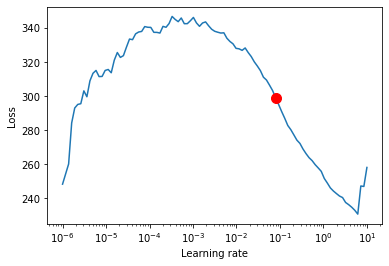

In [12]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

For the TemporalFusionTransformer, the optimal learning rate seems to be slightly lower than the suggested one. Further, we do not directly want to use the suggested learning rate because PyTorch Lightning sometimes can get confused by the noise at lower learning rates and suggests rates far too low. Manual control is essential. We decide to pick 0.03 as learning rate.

### Train model

If you have troubles training the model and get an error `AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'`, consider either uninstalling tensorflow or first execute

`import tensorflow as tf import tensorboard as tb` <br> `tf.io.gfile = tb.compat.tensorflow_stub.io.gfile.`

In [13]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=0,
    weights_summary="top",
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k


Training takes a couple of minutes on my gaming laptop but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs.` For example, we can monitor examples predictions on the training and validation set.

In [14]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

Missing logger folder: lightning_logs\lightning_logs

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial

Epoch 0:  97%|█████████▋| 30/31 [00:06<00:00,  4.99it/s, loss=308, v_num=0, train_loss_step=180.0]
Validation: 0it [00:00, ?it/s]
Epoch 1:  97%|█████████▋| 30/31 [00:06<00:00,  4.90it/s, loss=152, v_num=0, train_loss_step=153.0, val_loss=292.0, train_loss_epoch=368.0]
Validation: 0it [00:00, ?it/s]
Epoch 2:  97%|█████████▋| 30/31 [00:06<00:00,  4.95it/s, loss=152, v_num=0, train_loss_step=127.0, val_loss=214.0, train_loss_epoch=164.0]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|█████████▋| 30/31 [00:06<00:00,  4.99it/s, loss=136, v_num=0, train_loss_step=177.0, val_loss=205.0, train_loss_epoch=151.0]
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|█████████▋| 30/31 [00:05<00:00,  5.11it/s, loss=135, v_num=0, train_loss_step=125.0, val_loss=184.0, train_loss_epoch=138.0]
Validation: 0it [00:00, ?it/s]
Epoch 5:  97%|█████████▋| 30/31 [00:05<00:00,  5.01it/s, loss=116, v_num=0, train_loss_step=94.90, val_loss=179.0, train_loss_epoch=136.0]
Validation: 0it [00:00, ?it/s]
Epoch 6:  97%|██████

### Hyperparameter tuning

Hyperparamter tuning with [optuna](https://optuna.org/) is directly build into pytorch-forecasting. For example, we can use the **optimize_hyperparameters()** function to optimize the TFT’s hyperparameters.

In [15]:
warnings.filterwarnings("ignore") # avoid printing out absolute paths

# you might have to run this cell twice for some reason
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=200,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.001, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

[I 2022-07-31 16:45:26,544] A new study created in memory with name: no-name-67f03c82-6fa2-44ac-addb-406b2c85acc3
C:\Users\pavan\anaconda3\envs\pytorch_env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:171: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
[I 2022-07-31 16:51:22,053] Trial 0 finished with value: 167.38467407226562 and parameters: {'gradient_clip_val': 0.5411920797331429, 'hidden_size': 8, 'dropout': 0.17037077989469238, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0012058783495216177}. Best is trial 0 with value: 167.38467407226562.
C:\Users\pavan\anaconda3\envs\pytorch_env\li

{'gradient_clip_val': 0.5411920797331429, 'hidden_size': 8, 'dropout': 0.17037077989469238, 'hidden_continuous_size': 8, 'attention_head_size': 1, 'learning_rate': 0.0012058783495216177}


## Evaluate Performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [17]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

After training, we can make predictions with **predict()**. The method allows very fine-grained control over what it returns so that, for example, you can easily match predictions to your pandas dataframe. See its documentation for details. We evaluate the metrics on the validation dataset and a couple of examples to see how well the model is doing. Given that we work with only 21 000 samples the results are very reassuring and can compete with results by a gradient booster. We also perform better than the baseline model. Given the noisy data, this is not trivial.

In [20]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean().item()

260.6192932128906

We can now also look at sample predictions directly which we plot with **plot_prediction()**. As you can see from the figures below, forecasts look rather accurate. If you wonder, the grey lines denote the amount of attention the model pays to different points in time when making the prediction. This is a special feature of the Temporal Fusion Transformer.

In [21]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

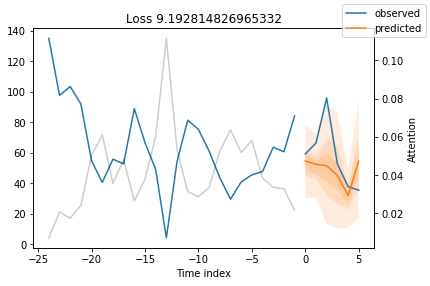

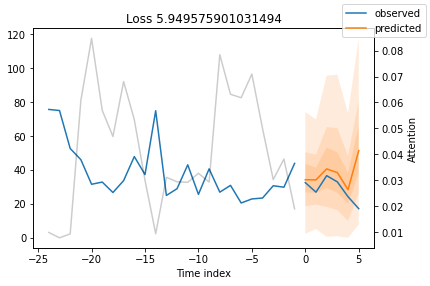

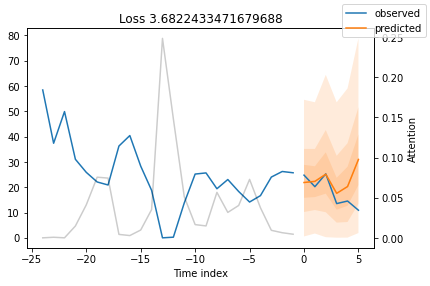

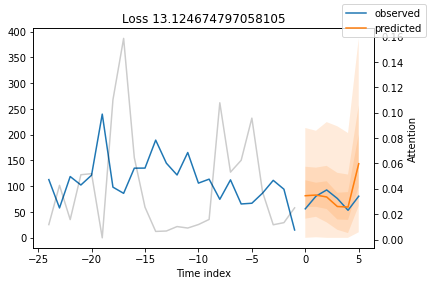

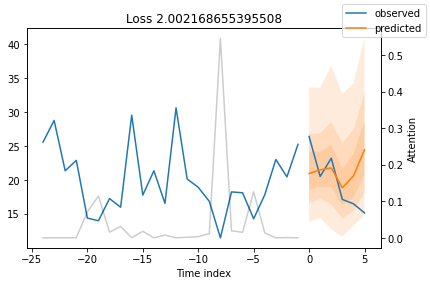

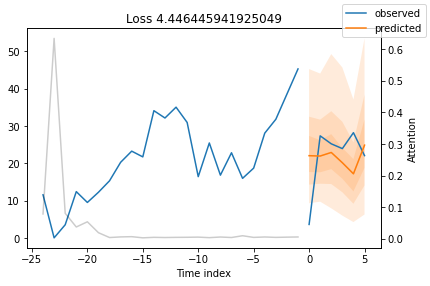

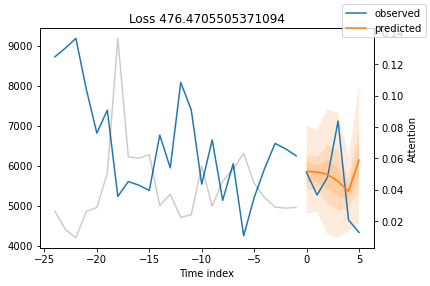

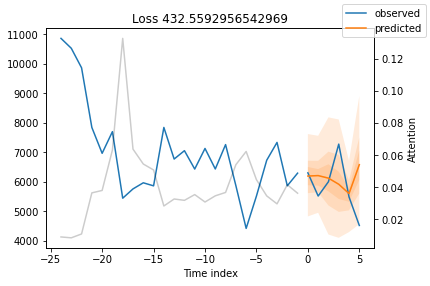

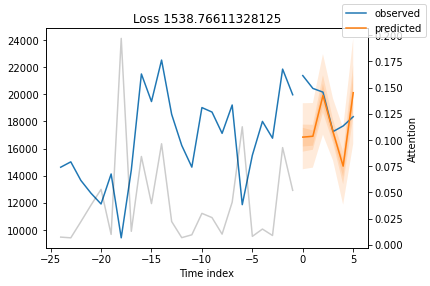

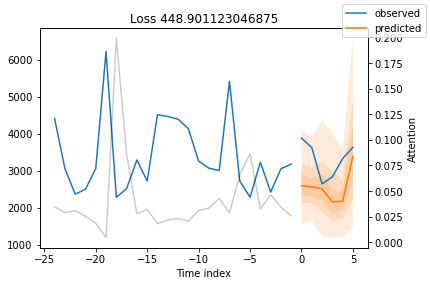

In [22]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Worst performers

Looking at the worst performers, for example in terms of SMAPE, gives us an idea where the model has issues with forecasting reliably. These examples can provide important pointers about how to improve the model. This kind of actuals vs predictions plots are available to all models. Of course, it is also sensible to employ additional metrics, such as MASE, defined in the **metrics** module. However, for the sake of demonstration, we only use SMAPE here.

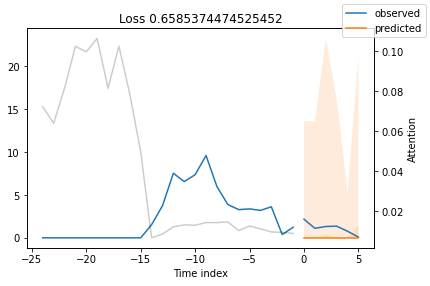

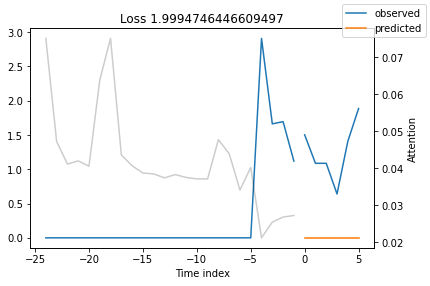

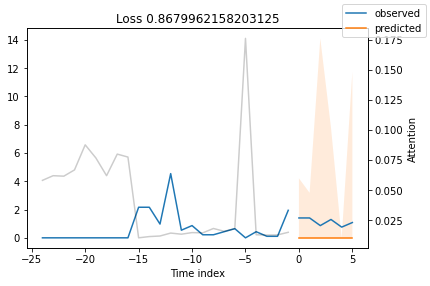

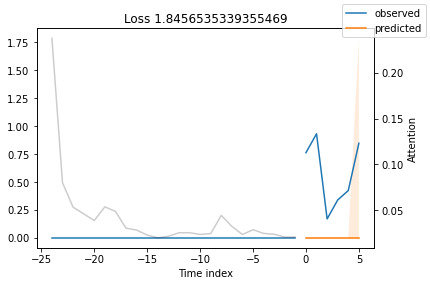

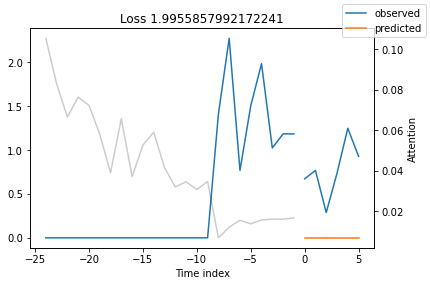

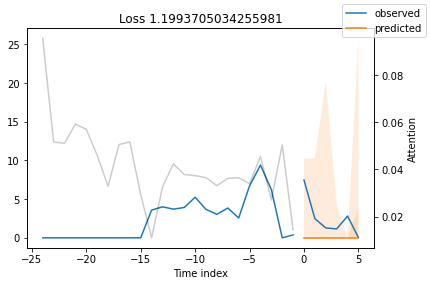

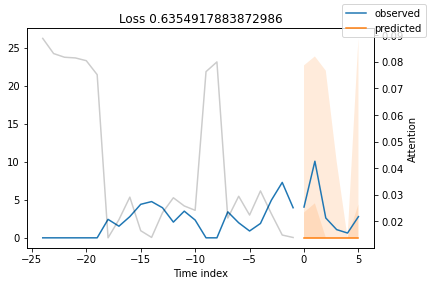

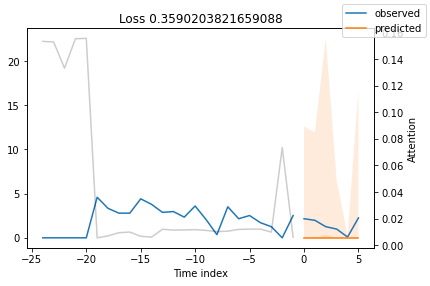

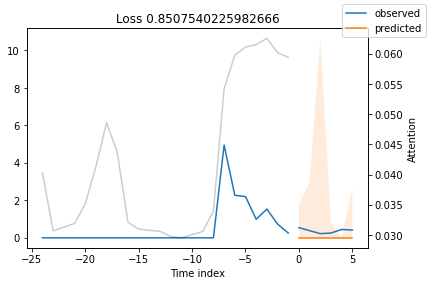

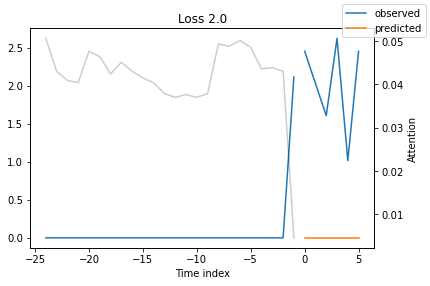

In [23]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variable

Checking how the model performs across different slices of the data allows us to detect weaknesses. Plotted below are the means of predictions vs actuals across each variable divided into 100 bins using the Now, we can directly predict on the generated data using the `calculate_prediction_actual_by_variable()` and `plot_prediction_actual_by_variable()` methods. The gray bars denote the frequency of the variable by bin, i.e. are a histogram.

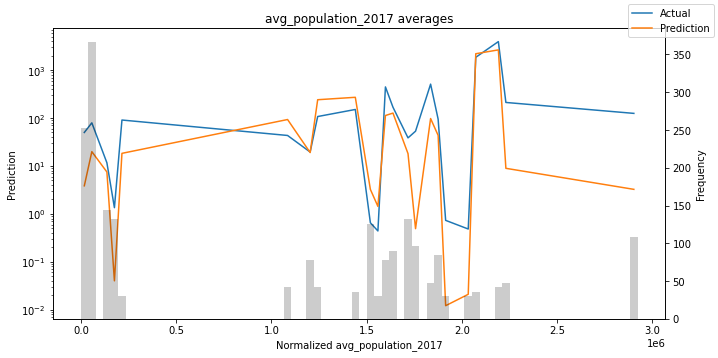

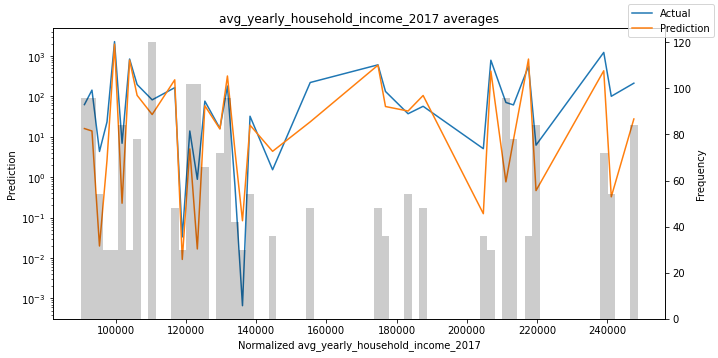

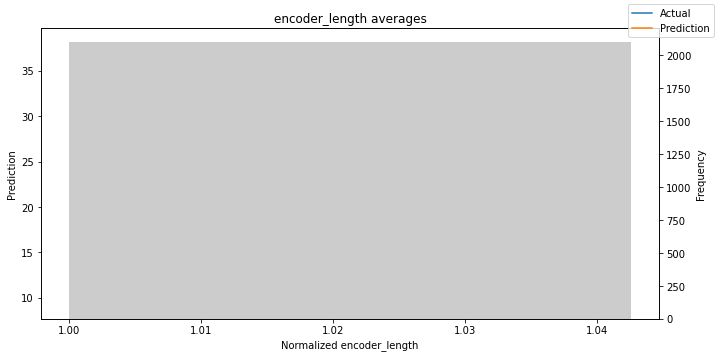

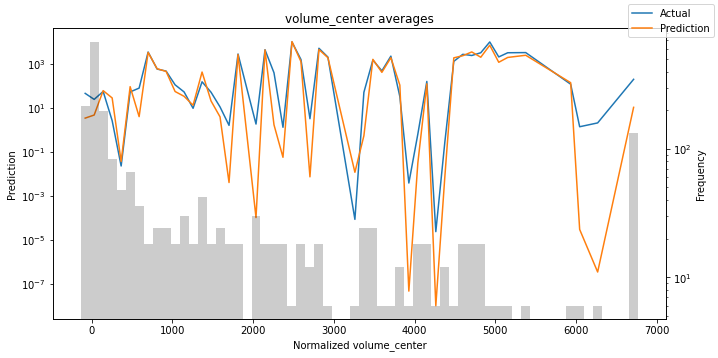

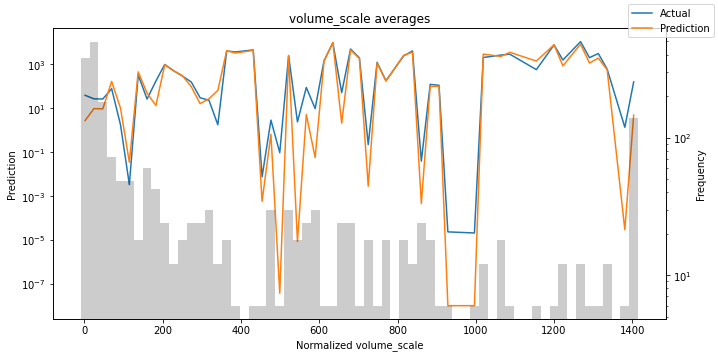

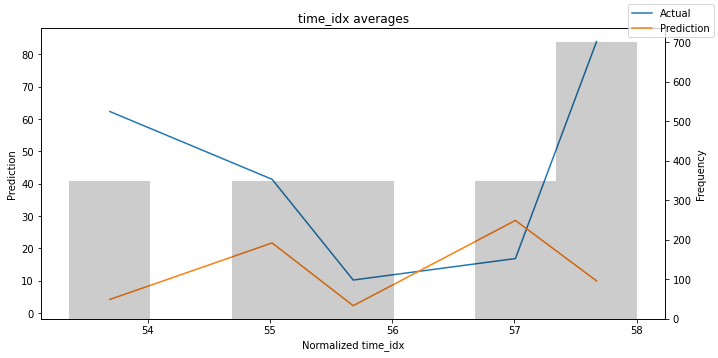

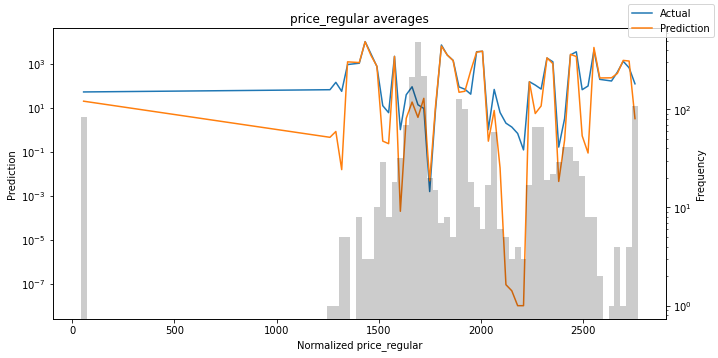

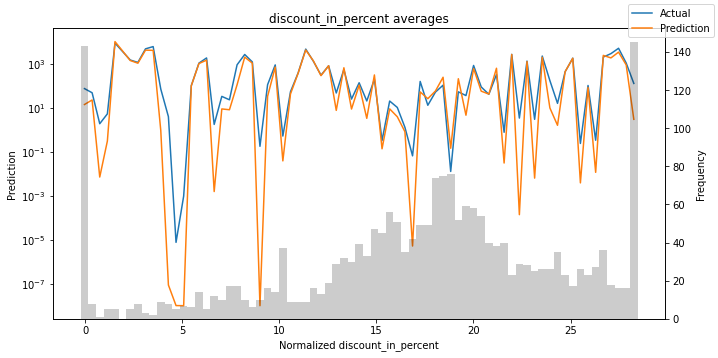

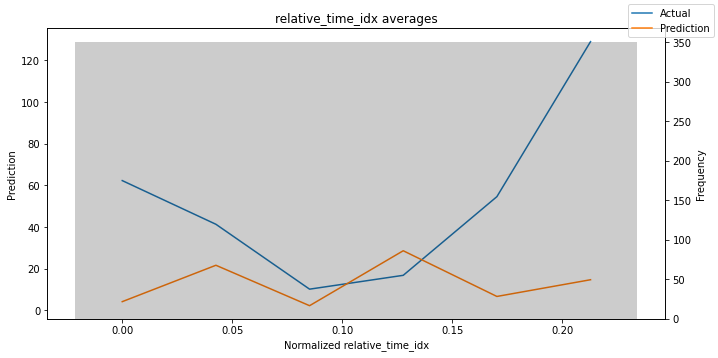

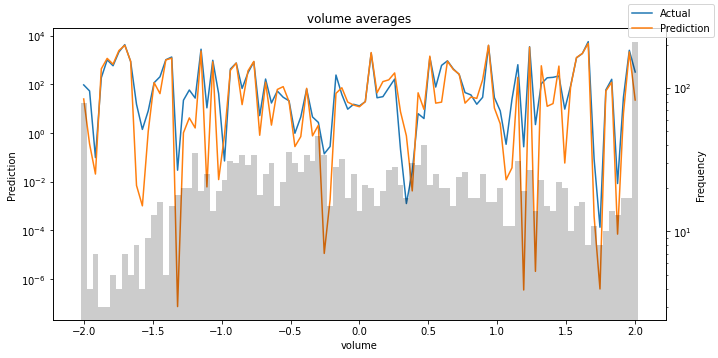

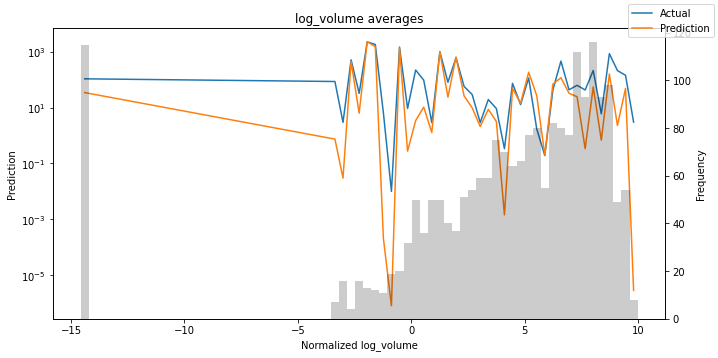

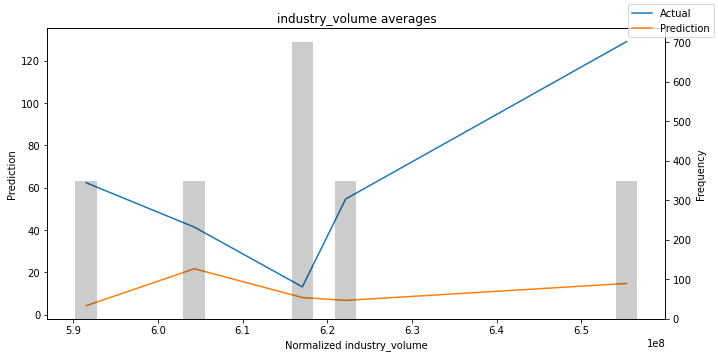

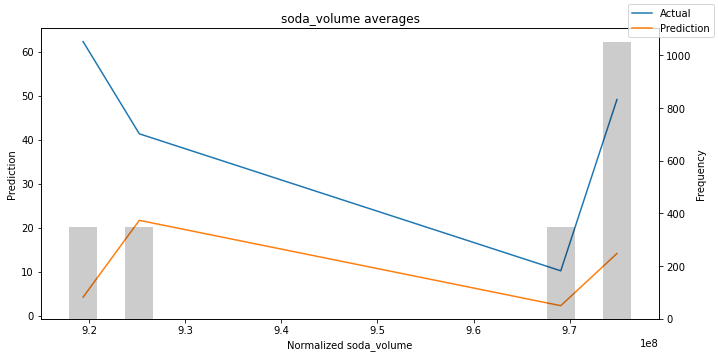

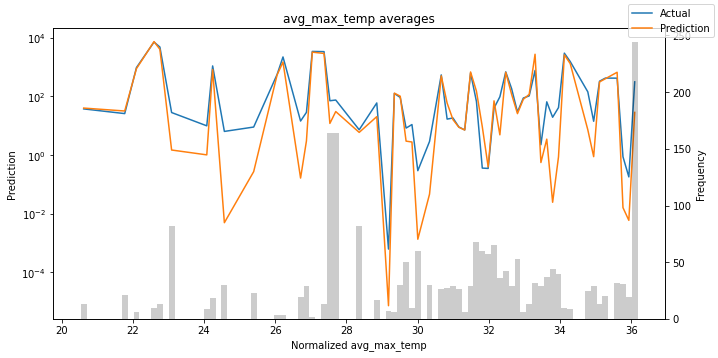

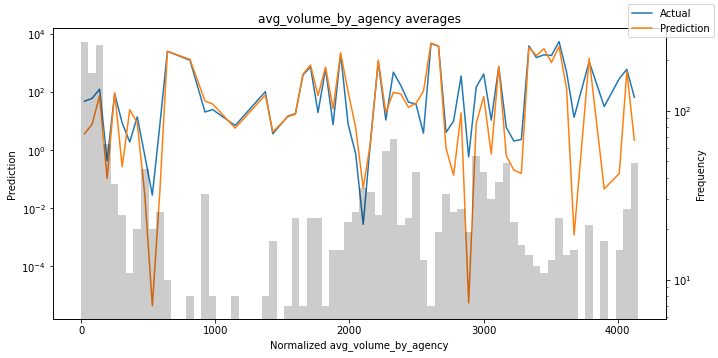

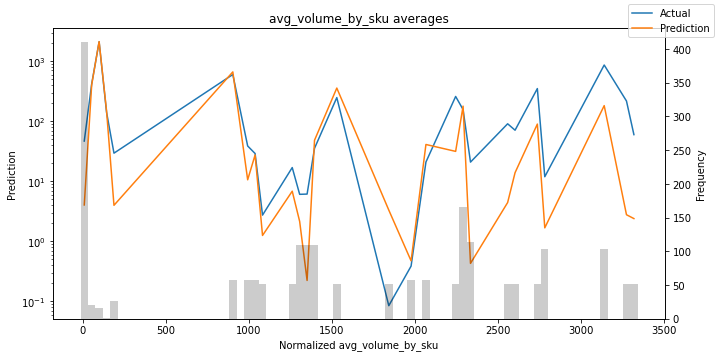

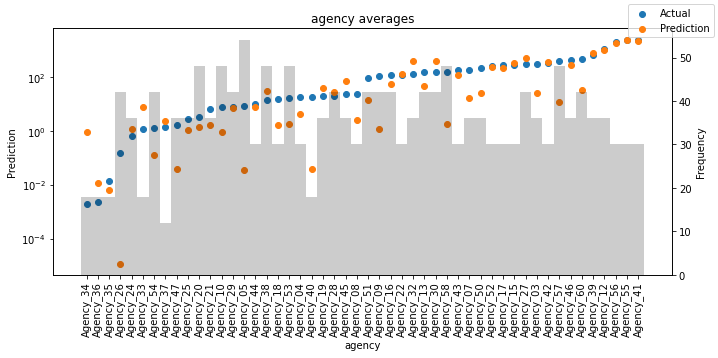

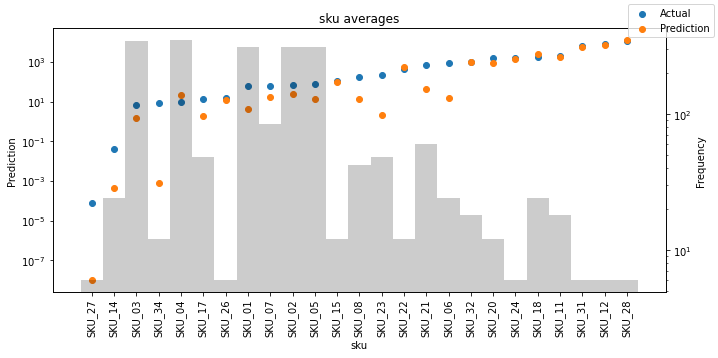

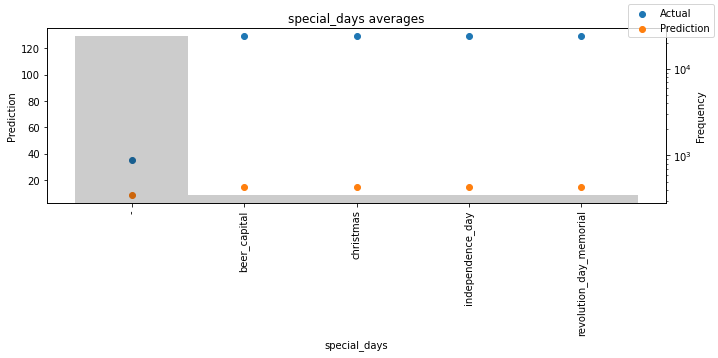

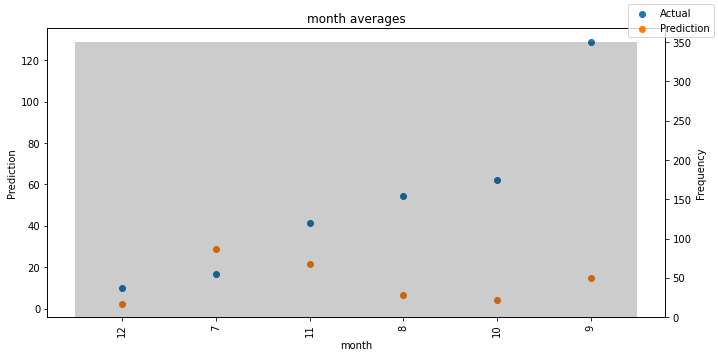

In [24]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

We can also predict into the future and interpret the model based on the attention. Refer to this [link](https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html) for more info.
